In [1]:
# ## un-comment out if running locally

# import os
# os.chdir('../')

In [ ]:
## if running locally, comment out the following code

!git clone https://github.com/nicktfranklin/SEM.git
import os
os.chdir('./SEM/')

!pip install tensorflow==1.9
!pip install keras==2.2

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from models import *
from sklearn import metrics

Using TensorFlow backend.


TensorFlow Version: 1.9.0
Keras      Version: 2.2.0
TensorFlow Check Passed


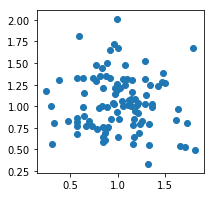

In [2]:
def build_2d_data(N, beta=0.1):
    """ 
    2d, Mulitvariate Guassian data
    """
    mu = [1, 1]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        x[n, :] = np.random.multivariate_normal(mu, Sigma)
        
    return x
X = build_2d_data(100)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:, 1])

In [3]:
D = 2
X_train = X[0:-1]; y_train = X[1:]

Now, we define some toy problem

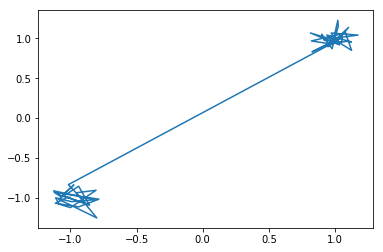

In [4]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * beta)
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * beta)
        
    return x

x_train = build_static_dataset(50, 0.01)
y = np.concatenate([np.zeros((25), dtype=int), np.ones((25), dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

In [5]:
# SEM parameters
lmda = 10.0  # stickyness parameter
alfa = .01  # concentration parameter

# prior over the event varaiance 
var_scale = 0.4
var_df = 10

# define plotting function
import seaborn as sns

def plot_segmentation(post, y):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        axes[0].scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5)
    axes[0].set_xlabel(r'$\mathbf{x}_{s,1}$')
    axes[0].set_ylabel(r'$\mathbf{x}_{s,2}$')


    axes[1].plot(post)
    y_hat = np.argmax(post, axis=1)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Cluster ID')
    print "Adjusted Mutual Information:", metrics.adjusted_mutual_info_score(y, y_hat)
    print "Adjusted Rand Score:", metrics.adjusted_rand_score(y, y_hat)
    print 
    print np.argmax(post, axis=1)

### Linear Events 

Run SEM: 100%|██████████| 50/50 [00:02<00:00, 22.89it/s]
/Users/nicholasfranklin/anaconda3/envs/sem/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


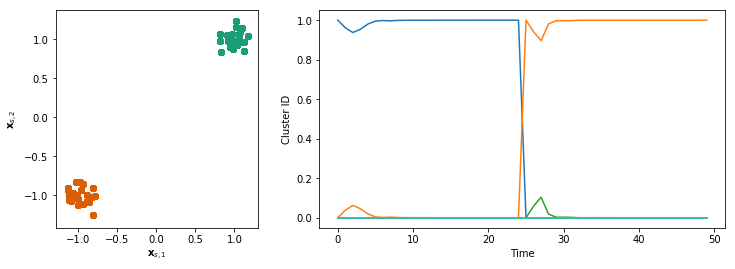

In [6]:
# Initialize keras model
sem_kwargs2 = dict(
    lmda=lmda, alfa=alfa, f_class=LinearEvent, 
    f_opts=dict(var_scale0=var_scale, var_df0=var_df, l2_regularization=0.4)
)

sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 50/50 [00:03<00:00, 16.35it/s]


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


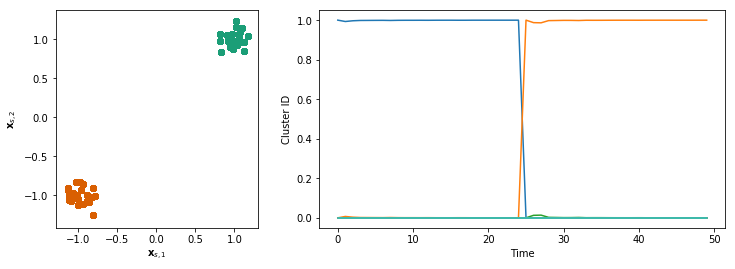

In [7]:
# Initialize keras model
sem_kwargs3 = dict(
    lmda=lmda, alfa=alfa, f_class=NonLinearEvent,
    f_opts=dict(var_scale0=var_scale, var_df0=var_df)
)

sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

###  Recurrent Linear Events

Run SEM: 100%|██████████| 50/50 [00:04<00:00, 10.35it/s]


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


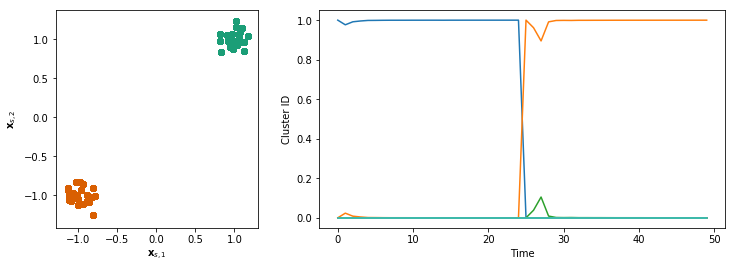

In [8]:
# Initialize keras model
sem_kwargs4 = dict(
    lmda=lmda, alfa=alfa, f_class=RecurentLinearEvent, 
    f_opts=dict(t=3, var_scale0=var_scale, var_df0=var_df)
)

sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 50/50 [00:05<00:00,  9.32it/s]


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


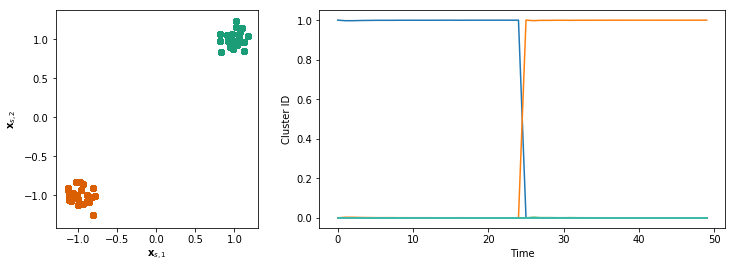

In [9]:
sem_kwargs5 = dict(
    lmda=lmda, alfa=alfa, f_class=RecurrentEvent,
    f_opts=dict(t=3, var_scale0=var_scale, var_df0=var_df)
               )

sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Gated Recurrent Unit Events

Run SEM: 100%|██████████| 50/50 [00:09<00:00, 12.90it/s]


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


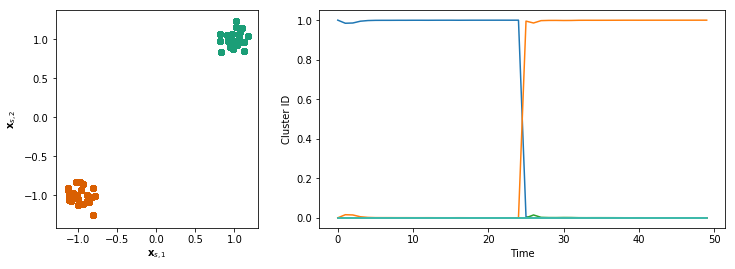

In [10]:
sem_kwargs6 = dict(
    lmda=lmda, alfa=alfa, f_class=GRUEvent,
    f_opts=dict(t=3, var_scale0=var_scale, var_df0=var_df)
               )

sem6 = SEM(**sem_kwargs6)
post = sem6.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 50/50 [00:15<00:00,  4.14it/s]


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


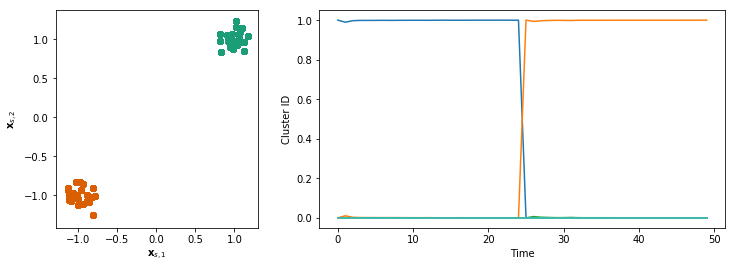

In [11]:
sem_kwargs7 = dict(
    lmda=lmda, alfa=alfa, f_class=LSTMEvent,
    f_opts=dict(t=3, var_scale0=var_scale, var_df0=var_df)
               )

sem7 = SEM(**sem_kwargs7)
post = sem7.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

# Alternating between 2 static events


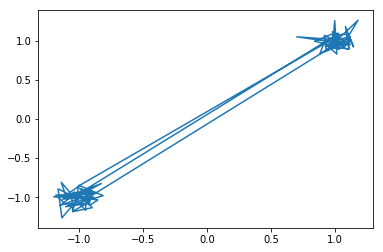

In [12]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events 

Run SEM: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


Adjusted Mutual Information: 0.6633529024545869
Adjusted Rand Score: 0.746803069054

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


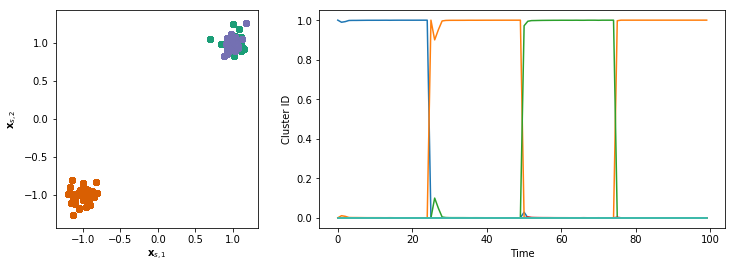

In [13]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:06<00:00, 16.66it/s]


Adjusted Mutual Information: 0.6633529024545869
Adjusted Rand Score: 0.746803069054

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


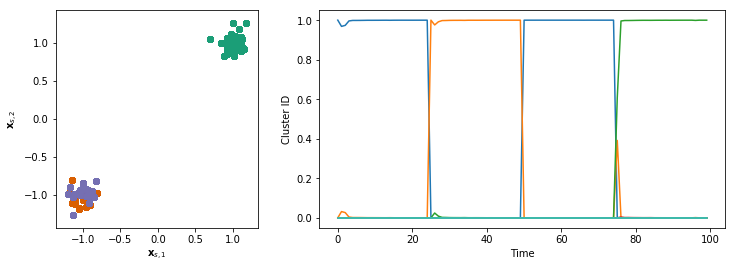

In [14]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


Adjusted Mutual Information: 0.6633529024545869
Adjusted Rand Score: 0.746803069054

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


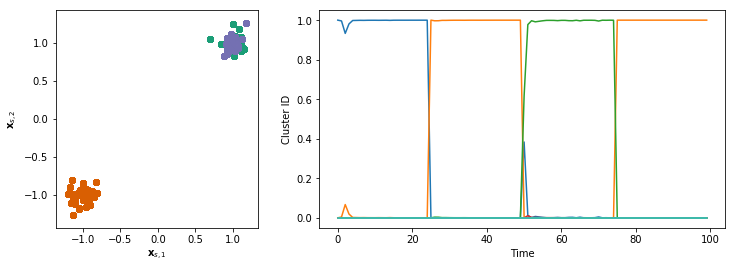

In [15]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Adjusted Mutual Information: 0.618198642387288
Adjusted Rand Score: 0.716796739117

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


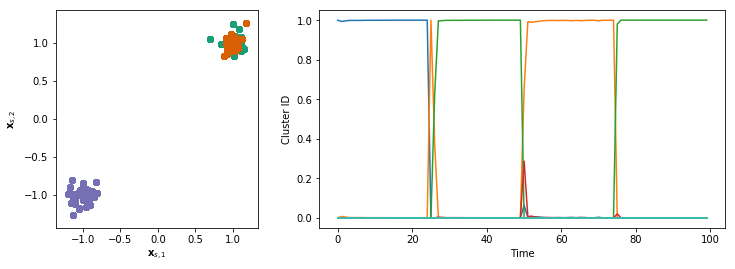

In [16]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


Adjusted Mutual Information: 0.618198642387288
Adjusted Rand Score: 0.716796739117

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


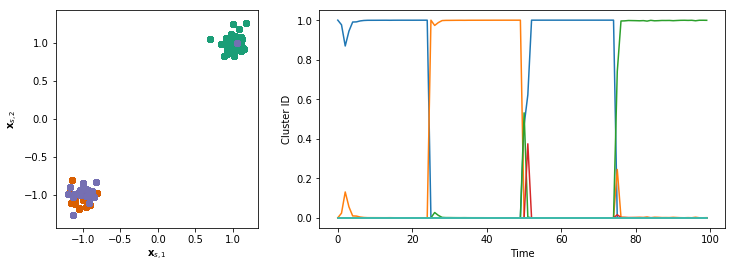

In [17]:
sem6 = SEM(**sem_kwargs6)
post = sem6.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [00:29<00:00,  8.33it/s]


Adjusted Mutual Information: 0.4636027222924853
Adjusted Rand Score: 0.472408318325

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


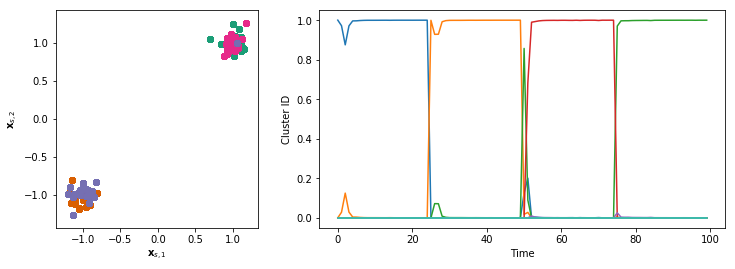

In [18]:
sem7 = SEM(**sem_kwargs7)
post = sem7.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

# Example of four events where the events correspond to movement in vector space

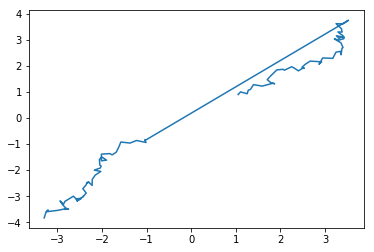

In [19]:
def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, N/2):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
y = np.concatenate([np.zeros(50, dtype=int), np.ones(50, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events 

Run SEM: 100%|██████████| 100/100 [00:07<00:00, 33.99it/s]


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


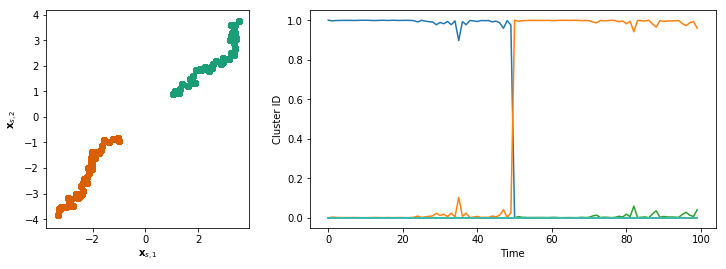

In [20]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


Adjusted Mutual Information: 0.37180231294150035
Adjusted Rand Score: 0.410593307329

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  8  9 10 11]


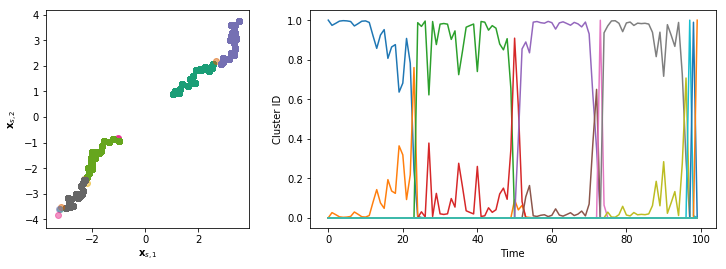

In [21]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


Adjusted Mutual Information: 0.6010544929412506
Adjusted Rand Score: 0.707797231854

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


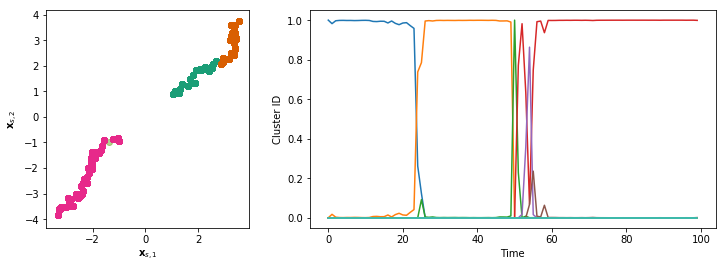

In [22]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Adjusted Mutual Information: 0.27023278240071996
Adjusted Rand Score: 0.585468579716

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10]


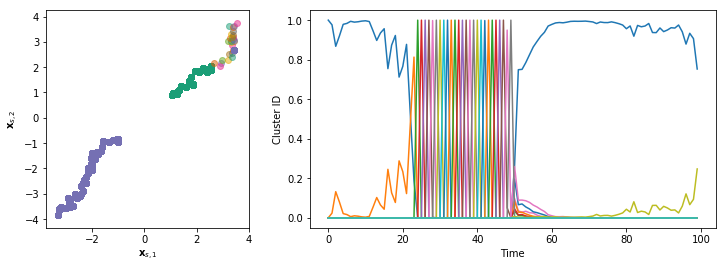

In [23]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [02:30<00:00,  9.80it/s]


Adjusted Mutual Information: 0.29600056353070553
Adjusted Rand Score: 0.605015442845

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9]


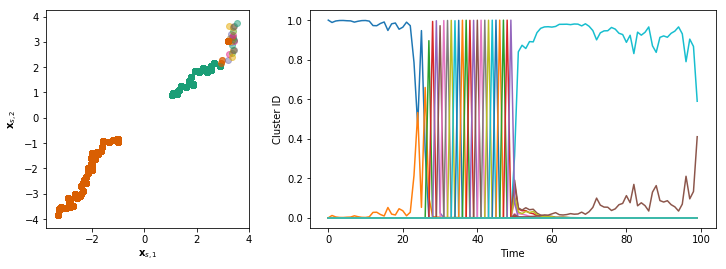

In [24]:
sem6 = SEM(**sem_kwargs6)
post = sem6.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [03:03<00:00,  6.55it/s]


Adjusted Mutual Information: 0.2960005635307055
Adjusted Rand Score: 0.605015442845

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20]


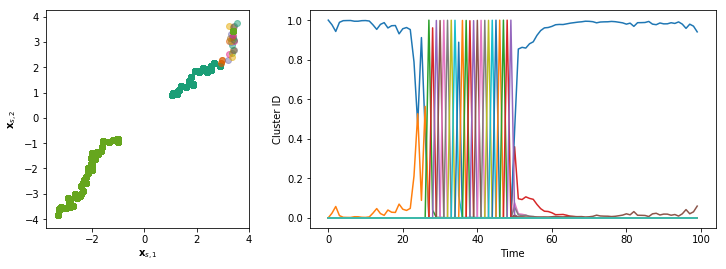

In [25]:
sem7 = SEM(**sem_kwargs7)
post = sem7.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

# Two alternating events with different levels of noise (10x)

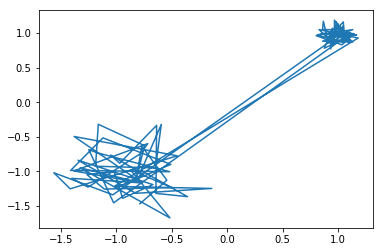

In [26]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.array([beta, beta * 10.])
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * stds[0])
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * stds[1])
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * stds[0])
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * stds[1])
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events

Run SEM: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


Adjusted Mutual Information: 0.6108921047051414
Adjusted Rand Score: 0.707797231854

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


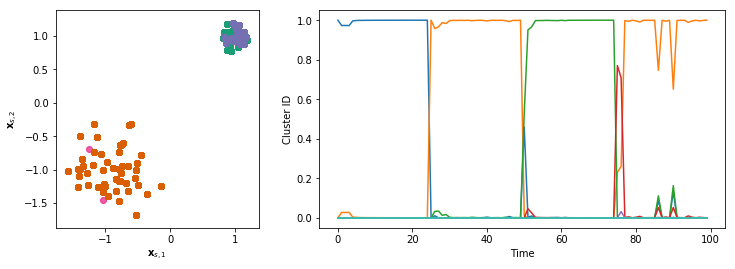

In [27]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


Adjusted Mutual Information: 0.6909515023347965
Adjusted Rand Score: 0.787401574803

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 1 1 1 1 1 1]


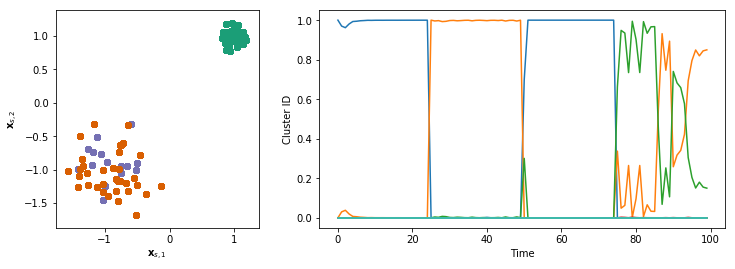

In [28]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:25<00:00, 18.32it/s]


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


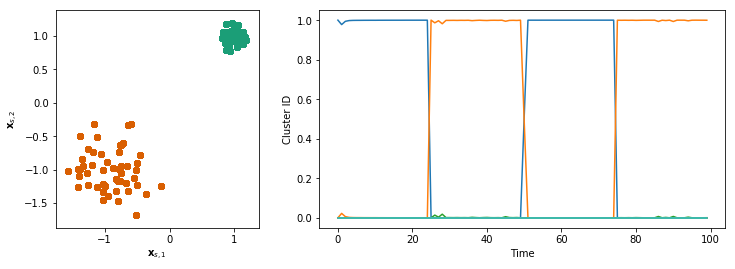

In [29]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


Adjusted Mutual Information: 0.9328598170547434
Adjusted Rand Score: 0.980196039208

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


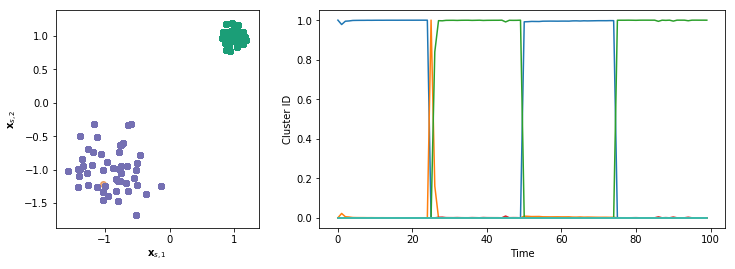

In [30]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [00:41<00:00, 13.01it/s]


Adjusted Mutual Information: 0.618198642387288
Adjusted Rand Score: 0.716796739117

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


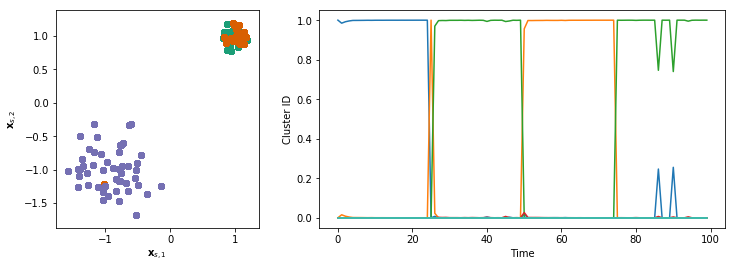

In [31]:
sem6 = SEM(**sem_kwargs6)
post = sem6.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Adjusted Mutual Information: 0.4678937574080887
Adjusted Rand Score: 0.473525260152

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


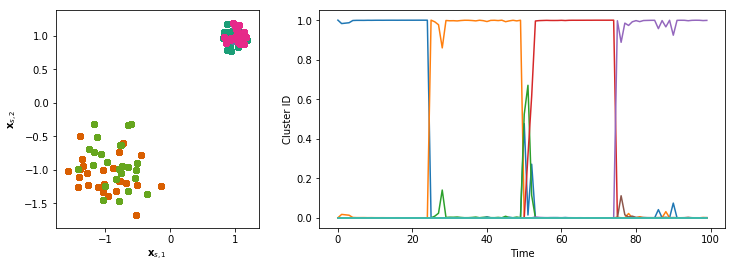

In [32]:
sem7 = SEM(**sem_kwargs7)
post = sem7.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

# 4 events where the events correspond to movement in vector space


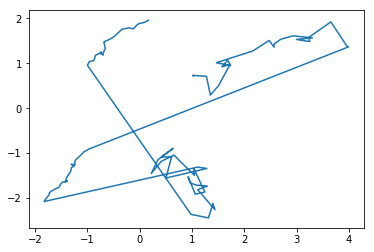

In [33]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigmas = [np.eye(2) * beta* 5.,
            np.eye(2) * beta / 5.,
            np.eye(2) * beta * 5.,
            np.eye(2) * beta / 5.]
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigmas[0])
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[0])
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigmas[1])
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[1])
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigmas[2])
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[2])
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigmas[3])
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[3])      
        
    return x

x_train = build_alternating_moving_events(100)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), 
                    np.ones(25, dtype=int)*2, np.ones(25, dtype=int)*3])

plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events

Run SEM: 100%|██████████| 100/100 [00:31<00:00, 16.01it/s]


Adjusted Mutual Information: 0.837508184011756
Adjusted Rand Score: 0.898119562167

[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


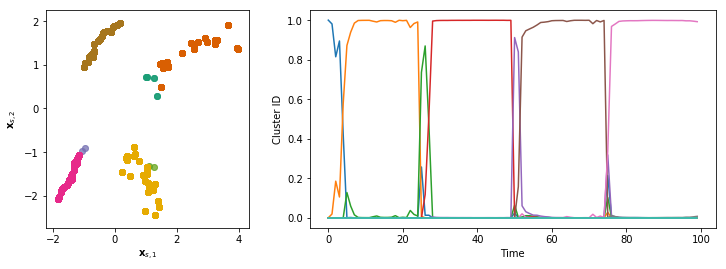

In [34]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Adjusted Mutual Information: 0.5694856056188389
Adjusted Rand Score: 0.710887051093

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  3  4  5  5  6  6  8  9
  9 10 11 12 13 14 15 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 17 17 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 12 12  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1]


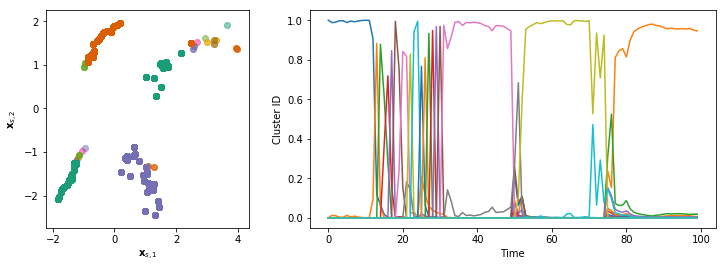

In [35]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [01:10<00:00,  2.47it/s]


Adjusted Mutual Information: 0.8530222524061416
Adjusted Rand Score: 0.924579264492

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 4 4 5 5 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


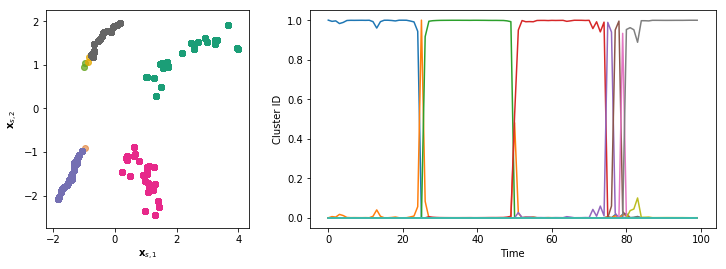

In [36]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [02:17<00:00,  1.37s/it]


Adjusted Mutual Information: 0.6221223699697089
Adjusted Rand Score: 0.55338637231

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11]


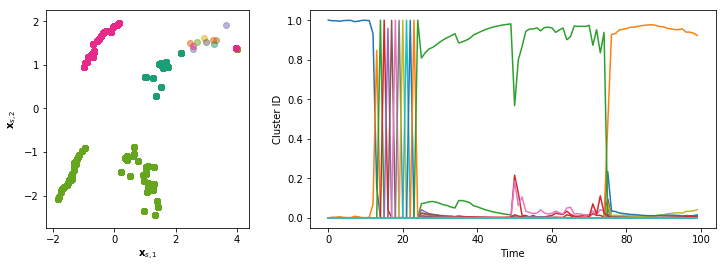

In [37]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [02:08<00:00, 16.88it/s]


Adjusted Mutual Information: 0.6221223699697089
Adjusted Rand Score: 0.55338637231

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1]


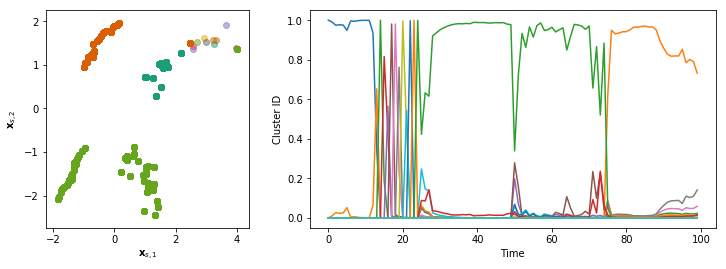

In [38]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


Adjusted Mutual Information: 0.707781618262721
Adjusted Rand Score: 0.786777366725

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7 7 8 8 8 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


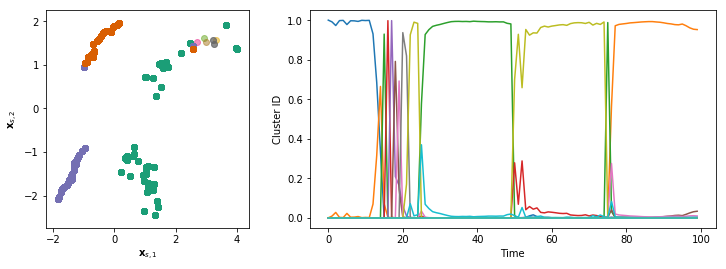

In [39]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)